In [2]:
import pandas as pd


file_list = [
    
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_1_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_2_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_3_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_4_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_5_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_6_7.csv',
    '/Users/rainfow/Desktop/Summer projects/companies_data/datetime_7_7.csv'
]

# 从CSV文件读取数据，并将日期列转换为datetime类型
df_list = [pd.read_csv(f, parse_dates=["IncorporationDate"]) for f in file_list]

# 合并所有数据框为一个大的数据框
df = pd.concat(df_list, ignore_index=True)
df.dropna(subset=['lat', 'long'], inplace=True)

In [3]:
def filter_by_postcode_prefix(df, prefix):
    # Split the postcode at the space to get the prefix
    df['PostCodePrefix'] = df['RegAddress.PostCode'].str.split().str[0]
    # Filter the DataFrame based on the prefix
    df_filtered = df[df['PostCodePrefix'].str.startswith(prefix)]
    return df_filtered

df_filtered = filter_by_postcode_prefix(df, 'CF14')
df_filtered.head()

,CompanyName,RegAddress.PostCode,lat,long,CompanyCategory,IncorporationDate,SICCode.SicText_1,PostCodePrefix
299,&SPACE LTD,CF14 0XQ,51.534693,-3.179534,Private Limited Company,2022-04-11,62090 - Other information technology service a...,CF14
418,'SGWENNU LIMITED,CF14 6DH,51.518695,-3.211434,Private Limited Company,2015-04-21,90020 - Support activities to performing arts,CF14
440,'WEDDINGBOOKER.COM' LIMITED,CF14 3AY,51.501567,-3.203555,Private Limited Company,2018-04-24,90030 - Artistic creation,CF14
635,. LTD,CF14 8LH,51.522153,-3.194287,Private Limited Company,2018-04-12,63990 - Other information service activities n...,CF14
698,0'BRIEN'S MAINTENANCE LIMITED,CF14 4ST,51.523159,-3.204966,Private Limited Company,2022-07-04,41201 - Construction of commercial buildings,CF14


In [4]:
import numpy as np

#df_filtered['Date'] = df_filtered['IncorporationDate'].dt.to_period('D')
df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


##df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().reset_index(name='CompanyCount')
##print(df_filtered_count.head(50))

df_filtered_count = df_filtered.groupby(['RegAddress.PostCode', 'Date']).agg({
    'CompanyName': lambda x: list(x),
    'lat': 'first',
    'long': 'first',
    'SICCode.SicText_1': lambda x: list(x),
}).reset_index()

# df_filtered_count['CompanyCount'] = df_filtered.groupby(['RegAddress.PostCode', 'Date']).size().values

df_filtered_count.head()


/var/folders/00/r2pslk7j4k158048921m90wm0000gn/T/ipykernel_2569/2322913796.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Date'] = pd.to_datetime(df_filtered['IncorporationDate'])


,RegAddress.PostCode,Date,CompanyName,lat,long,SICCode.SicText_1
0,CF14 0AB,2021-02-10,[BIFFY LTD],51.535540,-3.159611,[47910 - Retail sale via mail order houses or ...
1,CF14 0AD,2021-08-31,[MOORLYNCH LIMITED],51.545674,-3.166878,[98000 - Residents property management]
2,CF14 0AD,2022-08-26,[ST DENYS LIMITED],51.545674,-3.166878,[98000 - Residents property management]
3,CF14 0AF,1999-09-10,[ICHABOD'S INDUSTRIES LIMITED],51.536125,-3.159612,[69201 - Accounting and auditing activities]
4,CF14 0AF,2017-08-29,[SUPPLY CHAIN ASSOCIATES LIMITED],51.536125,-3.159612,"[74909 - Other professional, scientific and te..."


In [5]:
import re

def check_CompanyName(df):
    # Define the scoring function for company names
    def score_company_name(company_name_list):
        for company_name in company_name_list:
            # Check conditions
            # 1. Starts with a digit
            #if re.match(r'^\d', company_name):
            #   return 1
            # 2. Starts with consecutive digits
            if re.match(r'^\d{3,}', company_name):
                return 3
            # 3. Starts with a special character (!, @, #, etc.)
            if re.match(r'^[!@#\$%\^&\*\(\)_\+\-=\[\]\{\};:\'",<>\?]', company_name):
                return 3
            # 4. Starts with three or more consecutive identical letters
            if re.match(r'^(.)\1{2,}', company_name):
                return 3
            # 5.Name length is less than 8 and starts with a number followed by a letter
            if len(company_name) < 8 or re.match(r'^\d+[A-Za-z]', company_name):
                return 3
        return 0
    
    # Calculate score for each row
    df['name_score'] = df['CompanyName'].apply(score_company_name)
    
    return df


In [ ]:
# Apply the updated function to the original dataframe
df_scored_updated = check_CompanyName(df_filtered_count.copy())
df_scored_updated.head()

In [ ]:
df_scored_updated.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_scored_updated.csv', index=False)

In [ ]:
'''
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_similarity_scores(df):
    
    def compute_string_similarity(companies_1, companies_2):
        combined_companies = companies_1 + companies_2
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(combined_companies)
        cosine_similarities = cosine_similarity(tfidf_matrix)
        total_similarity = 0
        count = 0
        for i in range(len(companies_1)):
            for j in range(len(companies_1), len(combined_companies)):
                total_similarity += cosine_similarities[i][j]
                count += 1
        return total_similarity / count if count != 0 else 0

    def compute_score_v11(group):
        scores = [0] * len(group)

        # 如果该邮编地区的公司数量小于2，则无法进行比较，得分为0
        if len(group) >= 2:
            # 找出间隔最短的两个日期的索引
            min_diff = float('inf')
            idx1, idx2 = None, None
            sorted_dates = sorted(range(len(group)), key=lambda x: group.iloc[x]['Date'])

            for i in range(len(sorted_dates) - 1):
                date1 = pd.to_datetime(group.iloc[sorted_dates[i]]['Date'])
                date2 = pd.to_datetime(group.iloc[sorted_dates[i + 1]]['Date'])
                date_diff = (date2 - date1).days
                if date_diff < min_diff:
                    min_diff = date_diff
                    idx1, idx2 = sorted_dates[i], sorted_dates[i + 1]

            # 获取间隔最短的两个日期的公司名称列表
            recent_companies_1 = group.iloc[idx1]['CompanyName']
            recent_companies_2 = group.iloc[idx2]['CompanyName']

            # 确保公司名称总是在列表中
            if isinstance(recent_companies_1, str):
                recent_companies_1 = [recent_companies_1]
            if isinstance(recent_companies_2, str):
                recent_companies_2 = [recent_companies_2]

            # 计算公司名称的平均相似性
            avg_similarity = compute_string_similarity(recent_companies_1, recent_companies_2)

            # 设置一个阈值，如果平均相似性超过该阈值，则赋1分，否则赋0分
            threshold = 0.5
            if avg_similarity > threshold:
                scores[idx1] = 1
                scores[idx2] = 1

        return scores

    # 更新得分计算
    df = df_filtered_count
    similarity_score = df.groupby('RegAddress.PostCode').apply(compute_score_v11).reset_index(drop=True)
    df['similarity_score'] = [score for sublist in similarity_score for score in sublist]
    return df
'''

In [ ]:
# Apply the updated function to the original dataframe
df_similarity = compute_similarity_scores(df_filtered_count.copy())
df_similarity.head()

In [ ]:
df_similarity.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/df_similarity.csv', index=False)

In [ ]:
'''
def compute_siccode_similarity_scores(df):
    
    def compute_score_v12(group):
        scores = [0] * len(group)

        # 如果该邮编地区的公司数量小于2,则无法进行比较,得分为0
        if len(group) >= 2:
            # 找出间隔最短的两个日期的索引
            min_diff = float('inf')
            idx1, idx2 = None, None
            sorted_dates = sorted(range(len(group)), key=lambda x: group.iloc[x]['Date'])

            for i in range(len(sorted_dates) - 1):
                date1 = pd.to_datetime(group.iloc[sorted_dates[i]]['Date'])
                date2 = pd.to_datetime(group.iloc[sorted_dates[i + 1]]['Date'])
                date_diff = (date2 - date1).days
                if date_diff < min_diff:
                    min_diff = date_diff
                    idx1, idx2 = sorted_dates[i], sorted_dates[i + 1]

            # 获取间隔最短的两个日期的SICCode列表
            recent_siccode_1 = group.iloc[idx1]['SICCode.SicText_1']
            recent_siccode_2 = group.iloc[idx2]['SICCode.SicText_1']

            # 检查SICCode是否相同
            if recent_siccode_1 == recent_siccode_2:
                scores[idx1] = 1
                scores[idx2] = 1

        return scores

    # 更新得分计算
    siccode_similarity_score = df.groupby('RegAddress.PostCode').apply(compute_score_v12).reset_index(drop=True)
    df['siccode_score'] = [score for sublist in siccode_similarity_score for score in sublist]
    return df
'''

In [ ]:
# Apply the updated function to the original dataframe
df_siccode = compute_similarity_scores(df_filtered_count.copy())
df_siccode.head()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def integrated_similarity_scores(df):
    
    # 1. First function: compute_similarity_scores
    def compute_string_similarity(companies_1, companies_2):
        combined_companies = companies_1 + companies_2
        vectorizer = TfidfVectorizer()
        tfidf_matrix = vectorizer.fit_transform(combined_companies)
        cosine_similarities = cosine_similarity(tfidf_matrix)
        total_similarity = 0
        count = 0
        for i in range(len(companies_1)):
            for j in range(len(companies_1), len(combined_companies)):
                total_similarity += cosine_similarities[i][j]
                count += 1
        return total_similarity / count if count != 0 else 0

    def compute_name_score(group):
        scores = [0] * len(group)
        if len(group) >= 2:
            # 找出间隔最短的两个日期的索引
            min_diff = float('inf')
            idx1, idx2 = None, None
            sorted_dates = sorted(range(len(group)), key=lambda x: group.iloc[x]['Date'])
            
            for i in range(len(sorted_dates) - 1):
                date1 = pd.to_datetime(group.iloc[sorted_dates[i]]['Date'])
                date2 = pd.to_datetime(group.iloc[sorted_dates[i + 1]]['Date'])
                date_diff = (date2 - date1).days
                if date_diff < min_diff:
                    min_diff = date_diff
                    idx1, idx2 = sorted_dates[i], sorted_dates[i + 1]

            # 获取间隔最短的两个日期的公司名称列表
            recent_companies_1 = group.iloc[idx1]['CompanyName']
            recent_companies_2 = group.iloc[idx2]['CompanyName']
            if isinstance(recent_companies_1, str):
                recent_companies_1 = [recent_companies_1]
            if isinstance(recent_companies_2, str):
                recent_companies_2 = [recent_companies_2]
            # 计算公司名称的平均相似性
            avg_similarity = compute_string_similarity(recent_companies_1, recent_companies_2)
            threshold = 0.5
            if avg_similarity > threshold:
                scores[idx1] = 1
                scores[idx2] = 1
        return scores
    
    # 2. Second function: compute_siccode_similarity_scores
    def compute_siccode_score(group):
        scores = [0] * len(group)
        if len(group) >= 2:
            name_scores = compute_name_score(group)
            for i in range(len(name_scores)):
                
                # Only consider rows with similarity score of 1
                if name_scores[i] == 1:  
                    if i + 1 < len(name_scores) and name_scores[i + 1] == 1:
                        if group.iloc[i]['SICCode.SicText_1'] == group.iloc[i + 1]['SICCode.SicText_1']:
                            scores[i] = 1
                            scores[i + 1] = 1
        return scores
    
    # Applying functions and adding new columns to df
    df['name_similarity_score'] = [score for sublist in df.groupby('RegAddress.PostCode').apply(compute_name_score).reset_index(drop=True) for score in sublist]
    df['siccode_similarity_score'] = [score for sublist in df.groupby('RegAddress.PostCode').apply(compute_siccode_score).reset_index(drop=True) for score in sublist]
    
    return df


In [7]:
# Combine both scoring methods and then aggregate for the final result
def compute_combined_scores(df):
    # Get the scores from both methods
    df_name_scores = check_CompanyName(df)
    df_similarity_scores = integrated_similarity_scores(df)
    
    # Combine both scores
    df['name_score'] = df_name_scores['name_score']
    df['name_similarity_score'] = df_similarity_scores['name_similarity_score']
    df['siccode_similarity_score'] = df_similarity_scores['siccode_similarity_score']

    
    # Calculate the total score
    df['Total_Score'] = df['name_score'] + df['name_similarity_score']+df['siccode_similarity_score']
    
    return df

# Compute the combined scores
df_text_scores = compute_combined_scores(df_filtered_count)


In [8]:
# Group by postcode to get the total score for each postcode
similarity_scores_output = df_text_scores.groupby(['RegAddress.PostCode', 'lat', 'long']).agg({
    'CompanyName': 'size',
    'Total_Score': 'max'
}).reset_index()

similarity_scores_output.rename(columns={'CompanyName': 'CompanyCount'}, inplace=True)
similarity_scores_output.head(10)


,RegAddress.PostCode,lat,long,CompanyCount,Total_Score
0,CF14 0AB,51.535540,-3.159611,1,0
1,CF14 0AD,51.545674,-3.166878,2,0
2,CF14 0AF,51.536125,-3.159612,2,0
3,CF14 0AH,51.536829,-3.170213,2,0
4,CF14 0AN,51.538160,-3.164782,1,0
5,CF14 0AY,51.543626,-3.180977,1,0
6,CF14 0BD,51.544607,-3.182617,4,0
7,CF14 0BE,51.545351,-3.182839,4,0
8,CF14 0BG,51.534132,-3.177338,2,0
9,CF14 0EP,51.545926,-3.182940,1,0


In [ ]:
similarity_scores_output.to_csv('/Users/rainfow/Desktop/Summer projects/companies_data/similarity_scores_output.csv', index=False)

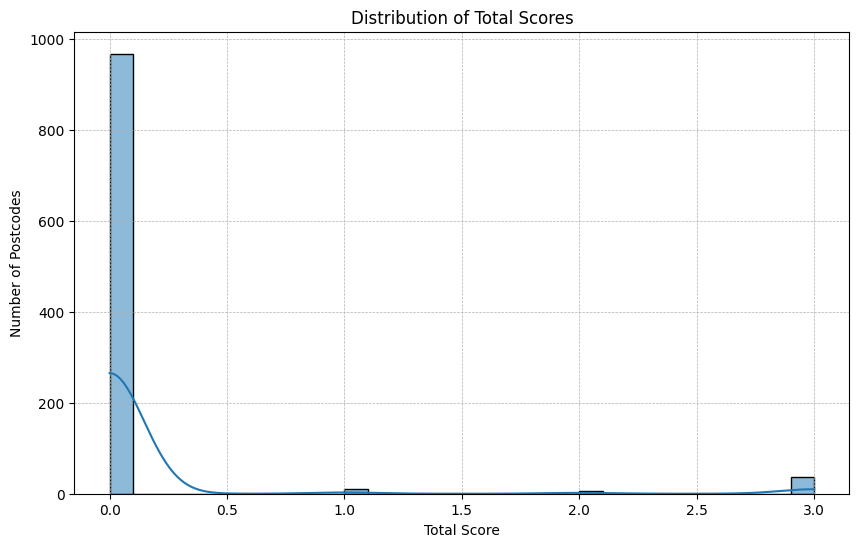

count    1021.000000
mean        0.129285
std         0.581525
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: Total_Score, dtype: float64

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistical description of Total_Score
score_description = similarity_scores_output["Total_Score"].describe()

# Plot the histogram for Total_Score
plt.figure(figsize=(10,6))
sns.histplot(similarity_scores_output["Total_Score"], kde=True, bins=30)
plt.title("Distribution of Total Scores")
plt.xlabel("Total Score")
plt.ylabel("Number of Postcodes")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

score_description


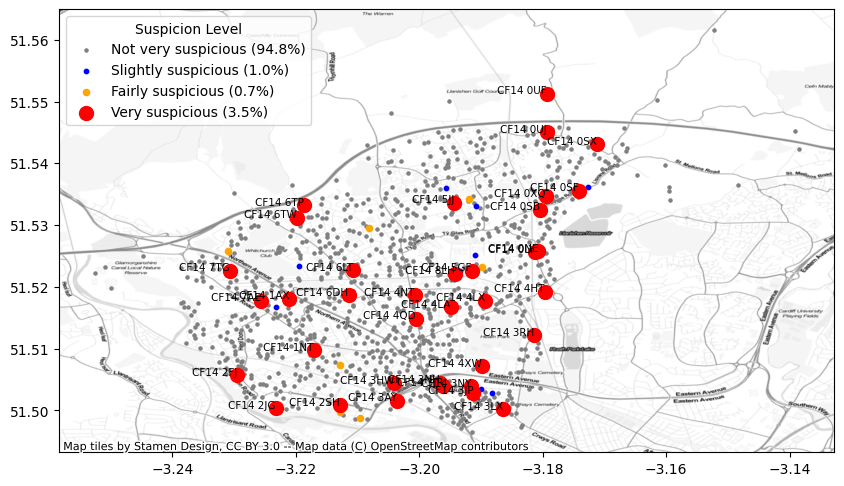

In [10]:
import matplotlib.pyplot as plt
import contextily as ctx
import pandas as pd

# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define the color and size mapping based on the quantiles of 'SumScores'
def map_color_size(score):
    threshold_1 = 0
    threshold_2 = 1
    threshold_3 = 2

    if score <= threshold_1:
        return 'gray', 5, 'Not very suspicious'
    elif score <= threshold_2:
        return 'blue', 10, 'Slightly suspicious'
    elif score <= threshold_3:
        return 'orange', 20, 'Fairly suspicious'
    else:
        return 'red', 100, 'Very suspicious'

similarity_scores_output['color'], similarity_scores_output['size'], similarity_scores_output['label'] = zip(*similarity_scores_output['Total_Score'].apply(map_color_size))

# Calculate the total number of postcodes
total_postcodes = len(similarity_scores_output)

# Define a dictionary for labels, colors, and sizes
label_dict = {
    'Not very suspicious': {'color': 'gray', 'size': 5},
    'Slightly suspicious': {'color': 'blue', 'size': 10},
    'Fairly suspicious': {'color': 'orange', 'size': 20},
    'Very suspicious': {'color': 'red', 'size': 100}
}

# Scatter plot
for label, attr in label_dict.items():
    idx = similarity_scores_output['label'] == label
    postcode_count = len(similarity_scores_output.loc[idx])
    percentage = postcode_count / total_postcodes * 100
    ax.scatter(similarity_scores_output.loc[idx, 'long'], similarity_scores_output.loc[idx, 'lat'], c=attr['color'], s=attr['size'], label=f'{label} ({percentage:.1f}%)')


    # If the label is "Very suspicious" (which corresponds to red), add the postal code text
    if label == "Very suspicious":
        for x, y, postcode in zip(similarity_scores_output.loc[idx, 'long'], similarity_scores_output.loc[idx, 'lat'], similarity_scores_output.loc[idx, 'RegAddress.PostCode']):
            ax.text(x, y, postcode, ha='right', fontsize=7.5, color='black')

# Add legend
ax.legend(title="Suspicion Level")

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Show the plot
plt.show()


In [13]:
import pandas as pd
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

df_hdbscan_3d = similarity_scores_output.copy()

# Prepare the data with three dimensions: latitude, longitude, and SumScores
data_3d = df_hdbscan_3d[['lat', 'long', 'Total_Score']].values

# Standardize the data
scaler = StandardScaler()
data_3d_scaled = scaler.fit_transform(data_3d)

# Create the HDBSCAN model with the same parameters
clusterer_3d = hdbscan.HDBSCAN(min_cluster_size=8, gen_min_span_tree=True)

# Fit the model with the three-dimensional standardized data
clusterer_3d.fit(data_3d_scaled)

# Get the labels
labels_3d = clusterer_3d.labels_

# Add the cluster labels to the dataframe
df_hdbscan_3d['cluster_3d'] = labels_3d

# Save or view the result
df_hdbscan_3d.head()


,RegAddress.PostCode,lat,long,CompanyCount,Total_Score,color,size,label,cluster_3d
0,CF14 0AB,51.535540,-3.159611,1,0,gray,5,Not very suspicious,1
1,CF14 0AD,51.545674,-3.166878,2,0,gray,5,Not very suspicious,1
2,CF14 0AF,51.536125,-3.159612,2,0,gray,5,Not very suspicious,1
3,CF14 0AH,51.536829,-3.170213,2,0,gray,5,Not very suspicious,1
4,CF14 0AN,51.538160,-3.164782,1,0,gray,5,Not very suspicious,1


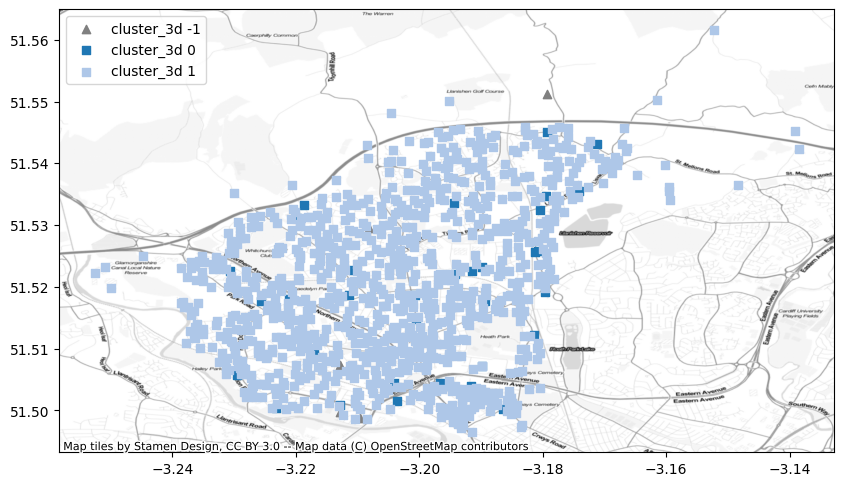

In [14]:
# Create a new figure
fig, ax = plt.subplots(figsize=(10, 10))

# Define a color map
cmap = plt.get_cmap('tab20')

# Get the number of clusters (excluding noise points)
n_clusters = len([c for c in np.unique(labels_3d) if c != -1])

# Scatter plot
for i in np.unique(df_hdbscan_3d['cluster_3d']):
    if i == -1:  # noise points in DBSCAN are labeled as -1
        color = 'gray'
        marker = '^'  # using triangle marker for noise points
    else:
        color = cmap(i % 20)  # use modulo 20 to ensure the color index is within the range of the color map
        marker = 's'
    idx = df_hdbscan_3d['cluster_3d'] == i
    ax.scatter(df_hdbscan_3d.loc[idx, 'long'], df_hdbscan_3d.loc[idx, 'lat'], 
               color=color, label=f"cluster_3d {i}", marker=marker)

# Add basemap
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Stamen.TonerLite)

# Add legend
ax.legend()

# Show the plot
plt.show()
